In [192]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
import mat73
import time

# ------------------     MATLAB STUFF  ----------------------------------
def get_matlab_variables(mat_file_path):
    variables = mat73.loadmat(mat_file_path)
    #double gets converted to np array by default
    value_func_data = variables['Vx']
    lx_data = variables['lx'] 
    tau2 = variables['tau2']

    #Deriv is cell which gets converted into list of lists
    deriv_x_data = np.array(variables['Deriv'][0])
    deriv_x_data = deriv_x_data.squeeze()
    deriv_y_data = np.array(variables['Deriv'][1])
    deriv_y_data = deriv_y_data.squeeze()
    deriv_th_data = np.array(variables['Deriv'][2])
    deriv_th_data = deriv_th_data.squeeze()

    #g is struct whic gets converted into dic
    #vs is cell which give a list
    x_coord=np.array(variables['g']['vs'][0])
    y_coord=np.array(variables['g']['vs'][1])
    th_coord=np.array(variables['g']['vs'][2])
    x_coord = x_coord.squeeze()
    y_coord = y_coord.squeeze()
    th_coord = th_coord.squeeze()

    matlab_var_dict = dict( value_func_data=value_func_data,
                            lx_data=lx_data,
                            deriv_x_data=deriv_x_data,
                            deriv_y_data=deriv_y_data,
                            deriv_th_data=deriv_th_data,
                            x_coord=x_coord,
                            y_coord=y_coord,
                            th_coord=th_coord,
                            tau2=tau2
                           )
    return matlab_var_dict

def get_value_function(matlab_var_dict):
   val_func_eval = RegularGridInterpolator(( matlab_var_dict['x_coord'], matlab_var_dict['y_coord'], matlab_var_dict['th_coord']), matlab_var_dict['value_func_data'] ,  bounds_error=False, fill_value=None)
   return val_func_eval

def get_lx_function(matlab_var_dict):
   lx_eval = RegularGridInterpolator(( matlab_var_dict['x_coord'], matlab_var_dict['y_coord']), matlab_var_dict['lx_data'] ,  bounds_error=False, fill_value=None)
   return lx_eval

def get_deriv_x_function(matlab_var_dict):
   deriv_x_eval = RegularGridInterpolator(( matlab_var_dict['x_coord'], matlab_var_dict['y_coord'], matlab_var_dict['th_coord'] ), matlab_var_dict['deriv_x_data'] ,  bounds_error=False, fill_value=None)
   return deriv_x_eval

def get_deriv_y_function(matlab_var_dict):
   deriv_y_eval = RegularGridInterpolator(( matlab_var_dict['x_coord'], matlab_var_dict['y_coord'], matlab_var_dict['th_coord'] ), matlab_var_dict['deriv_y_data'] ,  bounds_error=False, fill_value=None)
   return deriv_y_eval

def get_deriv_th_function(matlab_var_dict):
   deriv_th_eval = RegularGridInterpolator(( matlab_var_dict['x_coord'], matlab_var_dict['y_coord'], matlab_var_dict['th_coord'] ), matlab_var_dict['deriv_th_data'] ,  bounds_error=False, fill_value=None)
   return deriv_th_eval

def get_opt_control( deriv_x_fun, deriv_y_fun, deriv_th_fun, state, vMax, vMin, angleMax, u_mode = 'max'):
    # if strcmp(uMode, 'max')
    # uOpt{2} = (deriv{3}>=0)*obj.angleMax + (deriv{3}<0)*(-obj.angleMax);  %steering control
    # det1 = deriv{1} .* cos(y{3}) + deriv{2} .* sin(y{3}) + deriv{3} .* tan(uOpt{2}).*(1/obj.L);
    # uOpt{1} = (det1 >= 0) * max(obj.vRange) + (det1 < 0) * min(obj.vRange);%vel control
    x_deriv = deriv_x_fun(state)
    y_deriv = deriv_y_fun(state)
    th_deriv = deriv_th_fun(state)
    if u_mode == 'max':        
        opt_angle = angleMax * ( th_deriv >= 0 ) + (-angleMax) * ( th_deriv < 0 )
        det1 = x_deriv * np.cos(state[2]) + y_deriv * np.sin(state[2]) + th_deriv * np.tan(opt_angle)*(1/0.235) #0.235 is the wheelbase L
        opt_v = vMax * ( det1 >= 0 ) + vMin * ( det1 < 0 )
    else:
        raise NotImplementedError
    return opt_v, opt_angle

#---------------------- Load MATLAB ---------------------------------------------------------
#v1 baseline brt
matlab_var_dict= get_matlab_variables('/home/javier/jax_work/mppi/rc_car_mppi/brt_rc_wh_coarse_v1.mat')
data = matlab_var_dict['value_func_data']
data_lx = matlab_var_dict['lx_data']
val_fun = get_value_function(matlab_var_dict)
lx_fun = get_lx_function(matlab_var_dict)
deriv_x_fun = get_deriv_x_function(matlab_var_dict)
deriv_y_fun = get_deriv_y_function(matlab_var_dict)
deriv_th_fun = get_deriv_th_function(matlab_var_dict)


In [245]:
import jax
import jax.numpy as jnp
from jax import random, jit
import matplotlib.pyplot as plt
import time

@jit
def ackerman_dynamics(state, control, dt=0.1, L=0.235):
    x, y, theta = state
    v, delta = control
    
    x_dot = v * jnp.cos(theta)
    y_dot = v * jnp.sin(theta)
    theta_dot = v * jnp.tan(delta) * (1 / L)
    
    new_x = x + x_dot * dt
    new_y = y + y_dot * dt
    new_theta = theta + theta_dot * dt
    
    return new_x, new_y, new_theta

@jit
def cost_function(states, controls, x_target=0.0):
    x = states[0, :]
    v = controls[:, 0]
    distance_cost = jnp.sum((x - x_target) ** 2)
    return distance_cost 

@jit
def simulate_ackerman(initial_state, disturbed_controls, dt=0.1, L=0.235, v_min=0.5, v_max=1.5, delta_min=-0.5, delta_max=0.5):
    def step(state, control):
        v = jnp.clip(control[0], v_min, v_max)
        delta = jnp.clip(control[1], delta_min, delta_max)
        new_state = ackerman_dynamics(state, (v, delta), dt, L)
        return new_state, new_state
    
    # Use jax.lax.scan to iterate over the controls and accumulate the states
    _, states = jax.lax.scan(step, initial_state, disturbed_controls)
    
    # Convert states to a JAX array
    states = jnp.array(states)
    
    # Compute the cost for the entire array of states and controls
    total_cost = cost_function(states, disturbed_controls)
    
    return states, total_cost


# Vectorize the simulation function to run multiple trajectories in parallel
simulate_ackerman_parallel = jax.vmap(simulate_ackerman, in_axes=(None, 0))

# ------------------     SIMULATION INIT  ----------------------------------

# Example usage with jax.random
key = random.PRNGKey(0)

# Simulation parameters
hallucination_steps = 30
num_threads = 500
temperature = 0.01
experiment_steps = 10
initial_state = (0.0, 0.0, 0.0)

# Data structures
state_now = initial_state
state_history = []
control_history = []

# Generate nominal control inputs
nominal_velocities = jnp.ones(hallucination_steps)
nominal_steering_angles = jnp.zeros(hallucination_steps)
nominal_controls = jnp.stack((nominal_velocities, nominal_steering_angles), axis=1)


# ------------------     SIMULATION LOOP  ----------------------------------

for i in range(experiment_steps):

    # Generate random noise for multiple trajectories
    control_noise = random.normal(key, shape=(num_threads, hallucination_steps, 2)) * jnp.array([0.1, 0.05])  # Adjust the scale of noise as needed

    # Combine controls and noise before passing to the simulation function
    disturbed_controls = nominal_controls + control_noise    

    # Perform the simulation
    start_time = time.time()
    states_parallel, costs_parallel = simulate_ackerman_parallel(state_now, disturbed_controls)
    end_time = time.time()
    
    # Update nominal controls using the costs and noise
    weights = jnp.exp(-temperature * (costs_parallel))
    weights = weights[:, jnp.newaxis, jnp.newaxis]  # Adjust shape for broadcasting
    nominal_controls = nominal_controls + jnp.sum(weights * control_noise, axis=0) / jnp.sum(weights)
    # clip the controls to the valid range
    nominal_controls = jnp.clip(nominal_controls, jnp.array([0.5, -0.5]), jnp.array([1.5, 0.5]))
    
    # Apply the first control from the updated nominal controls to the system and store the new state
    state_now = ackerman_dynamics(state_now, nominal_controls[0])
    state_history.append(state_now)
    control_history.append(nominal_controls[0])
    
    # Move the control sequence one step forward and maintain the last control
    nominal_controls = jnp.roll(nominal_controls, -1, axis=0)
    nominal_controls = nominal_controls.at[-1].set(nominal_controls[-2])

    # Print the elapsed time
    print(f"Elapsed time for rollouts {end_time - start_time:.4f} seconds")
    

# Print shapes of the states and costs
print("Shape of states array:", jnp.array(states_parallel).shape)
print("Shape of costs array:", jnp.array(costs_parallel).shape)



Elapsed time for rollouts 0.1387 seconds
Elapsed time for rollouts 0.1199 seconds
Elapsed time for rollouts 0.0009 seconds
Elapsed time for rollouts 0.0009 seconds
Elapsed time for rollouts 0.0009 seconds
Elapsed time for rollouts 0.0009 seconds
Elapsed time for rollouts 0.0009 seconds
Elapsed time for rollouts 0.0008 seconds
Elapsed time for rollouts 0.0011 seconds
Elapsed time for rollouts 0.0010 seconds
Shape of states array: (500, 3, 30)
Shape of costs array: (500,)


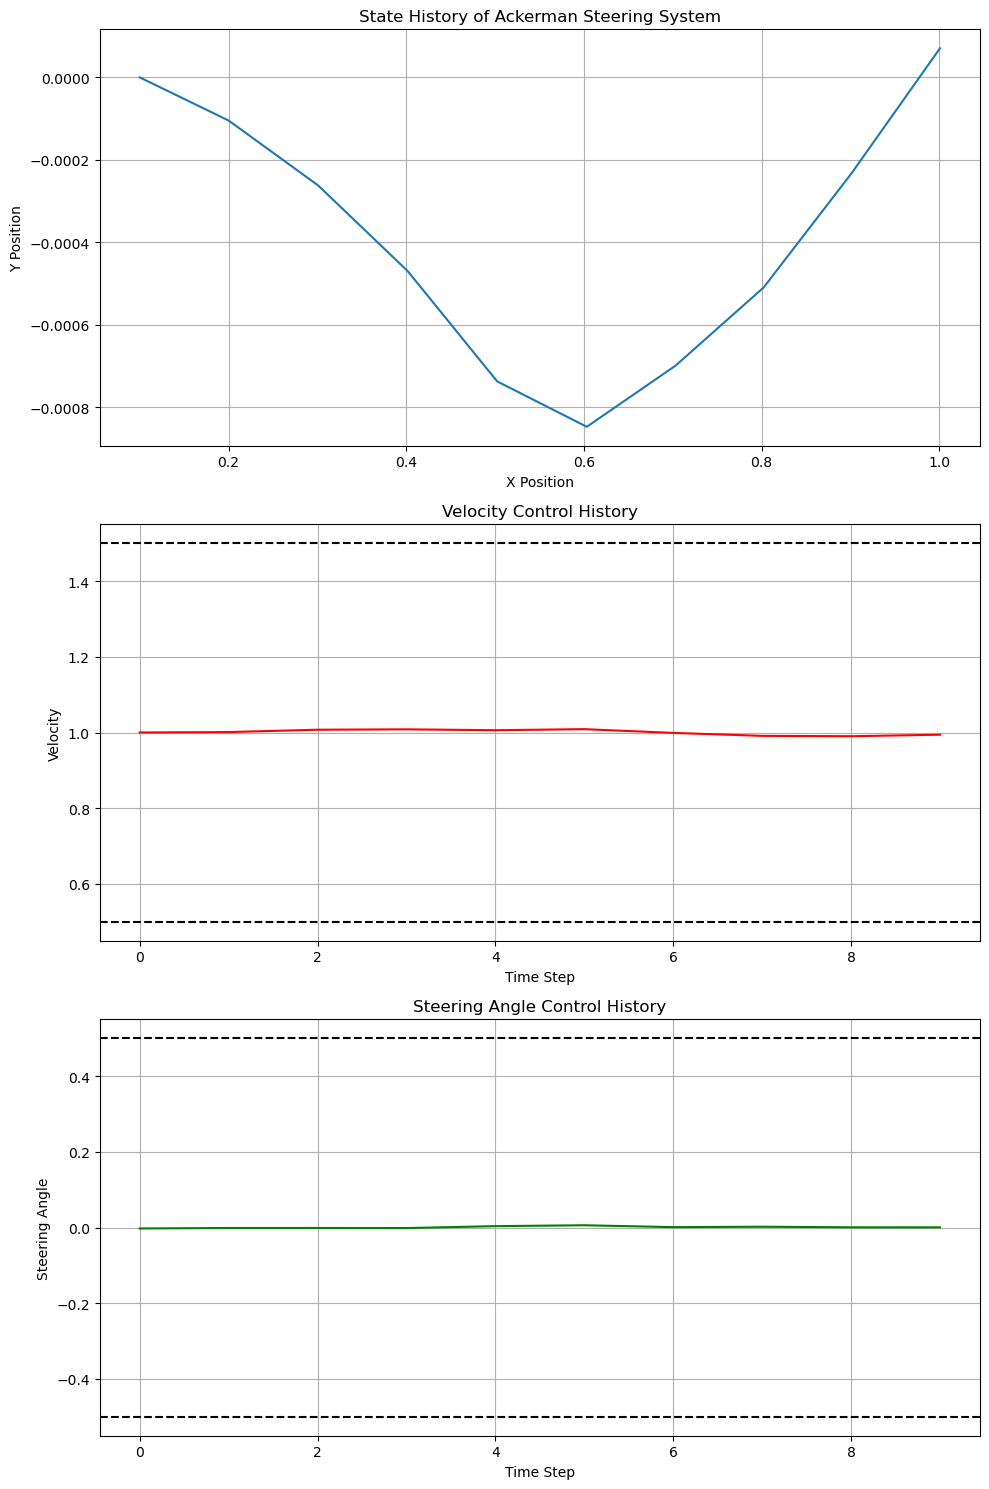

In [246]:
# Convert state and control history to JAX arrays
state_history = jnp.array(state_history)
control_history = jnp.array(control_history)

# Extract x and y positions from state history
x_history = state_history[:, 0]
y_history = state_history[:, 1]

# Extract control components from control history
v_history = control_history[:, 0]
delta_history = control_history[:, 1]

# Define min and max valid controls
v_min, v_max = 0.5, 1.5
delta_min, delta_max = -0.5, 0.5

# Create a figure with 3 subplots
plt.figure(figsize=(10, 15))

# Plot state history
plt.subplot(3, 1, 1)
plt.plot(x_history, y_history)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('State History of Ackerman Steering System')
plt.grid(True)

# Plot first component of control history (velocity)
plt.subplot(3, 1, 2)
plt.plot(v_history, color = 'r')
plt.axhline(y=v_min, color='k', linestyle='--', label='Min Velocity')
plt.axhline(y=v_max, color='k', linestyle='--', label='Max Velocity')
plt.xlabel('Time Step')
plt.ylabel('Velocity')
plt.title('Velocity Control History')
#plt.legend()
plt.grid(True)

# Plot second component of control history (steering angle)
plt.subplot(3, 1, 3)
plt.plot(delta_history, color='g')
plt.axhline(y=delta_min, color='k', linestyle='--', label='Min Steering Angle')
plt.axhline(y=delta_max, color='k', linestyle='--', label='Max Steering Angle')
plt.xlabel('Time Step')
plt.ylabel('Steering Angle')
plt.title('Steering Angle Control History')
#plt.legend()
plt.grid(True)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

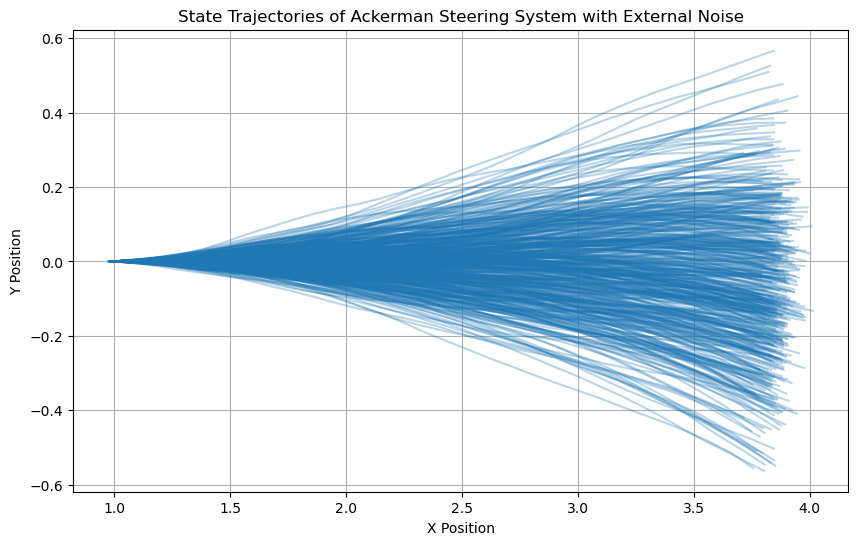

Total costs for each trajectory: [190.25058 198.9017  195.13821 197.67249 205.04544 204.10252 198.3346
 201.17456 204.59709 204.78596 206.99983 195.89981 199.51073 207.10889
 205.79276 193.48456 203.90535 206.71559 195.50105 211.13782 201.41035
 197.38544 200.82172 206.03201 202.8135  197.09561 205.72742 196.94377
 202.28157 208.05313 196.20676 190.6085  193.27802 198.05084 200.55829
 190.09508 196.47855 193.77379 198.05777 204.545   195.47734 205.43492
 202.70372 197.82619 197.0013  196.86409 201.72939 201.61761 205.01364
 204.75978 203.68736 201.85178 187.48695 205.39134 199.20636 194.89783
 198.36089 190.29034 190.47955 206.88135 187.08025 198.75296 187.95665
 200.27522 200.889   206.7342  198.65138 197.82657 196.35504 193.04456
 200.19673 207.61975 195.09273 194.34355 199.46487 202.12708 198.11528
 202.67323 203.02087 195.04834 197.77438 198.43794 199.28716 198.45705
 199.62877 202.97224 204.438   200.38608 204.2756  186.66328 204.14526
 202.77904 198.74782 192.58044 189.98589 199.

In [247]:
# Visualize the state trajectories
plt.figure(figsize=(10, 6))
for i in range(num_threads):
    x_coords = jnp.array(states_parallel)[i, 0, :]
    y_coords = jnp.array(states_parallel)[i, 1, :]
    plt.plot(x_coords, y_coords, color='tab:blue', alpha=0.3)  
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('State Trajectories of Ackerman Steering System with External Noise')
plt.grid(True)
plt.show()

# Print the total cost for each trajectory
print("Total costs for each trajectory:", costs_parallel)

In [158]:
# Ensure you are in a Jupyter Notebook environment
# Use %timeit to measure the execution time
%timeit -n 20 -r 10 states_parallel = simulate_ackerman_parallel(initial_state, disturbed_controls); jax.block_until_ready(states_parallel)

1.12 ms ± 269 µs per loop (mean ± std. dev. of 10 runs, 20 loops each)


In [182]:
print(weights.shape)
print(nominal_controls)



(500, 1, 1)
[[ 1.039711    0.01765764]
 [ 1.0074672   0.00519869]
 [ 0.96606696  0.007281  ]
 [ 0.9615024   0.00447851]
 [ 0.9801415  -0.00564309]
 [ 0.94756657 -0.01174481]
 [ 0.97348964  0.00171583]
 [ 0.9636962  -0.00710386]
 [ 0.97637767 -0.004498  ]
 [ 0.9801328  -0.00609889]
 [ 0.9998733  -0.00753594]
 [ 1.0123044  -0.01116615]
 [ 1.0541272  -0.00384482]
 [ 1.044677    0.0017677 ]
 [ 1.0140316   0.01093596]
 [ 1.0321149   0.01395705]
 [ 1.0209965   0.00912814]
 [ 0.99600923  0.00142064]
 [ 0.9849608  -0.00857907]
 [ 0.9690888  -0.01658782]
 [ 0.9355504  -0.01669665]
 [ 0.93926543 -0.01854621]
 [ 0.9779749  -0.01573292]
 [ 0.9815071  -0.00655838]
 [ 1.0102152  -0.01472004]
 [ 1.0293171  -0.01982952]
 [ 1.0305226  -0.01046063]
 [ 1.0261477  -0.00614794]
 [ 1.0347781  -0.01078175]
 [ 1.0299275   0.00793535]]


In [183]:
print(jnp.roll(nominal_controls, -1, axis=0))

[[ 1.0074672   0.00519869]
 [ 0.96606696  0.007281  ]
 [ 0.9615024   0.00447851]
 [ 0.9801415  -0.00564309]
 [ 0.94756657 -0.01174481]
 [ 0.97348964  0.00171583]
 [ 0.9636962  -0.00710386]
 [ 0.97637767 -0.004498  ]
 [ 0.9801328  -0.00609889]
 [ 0.9998733  -0.00753594]
 [ 1.0123044  -0.01116615]
 [ 1.0541272  -0.00384482]
 [ 1.044677    0.0017677 ]
 [ 1.0140316   0.01093596]
 [ 1.0321149   0.01395705]
 [ 1.0209965   0.00912814]
 [ 0.99600923  0.00142064]
 [ 0.9849608  -0.00857907]
 [ 0.9690888  -0.01658782]
 [ 0.9355504  -0.01669665]
 [ 0.93926543 -0.01854621]
 [ 0.9779749  -0.01573292]
 [ 0.9815071  -0.00655838]
 [ 1.0102152  -0.01472004]
 [ 1.0293171  -0.01982952]
 [ 1.0305226  -0.01046063]
 [ 1.0261477  -0.00614794]
 [ 1.0347781  -0.01078175]
 [ 1.0299275   0.00793535]
 [ 1.039711    0.01765764]]
